In [1]:
import nltk
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC  
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

C:\Users\Anaji\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [2]:
#Loading the data
def load_Data(path):
    df = pd.read_csv(path)
    return df


In [3]:
#Loading the Train data
def Train_Preprocess(df):
    df = df[['tweet', 'sentiment']]
    df = df.dropna()
    return df

#Loading the Test data
def Test_Preprocess(df):
    ID = df['tweet_id']
    df = df[['tweet']]
    return ID, df

In [4]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
df.head()

,tweet,sentiment
0,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1


In [5]:
path = 'data/test.csv'
data = load_Data(path)
ID,Test_df = Test_Preprocess(data)
Test_df.head()

,tweet
0,"Audience Q: What prototyping tools do you use? Sketchbooks/sharpie pens, photoshop, Balsamic, Google docs, Axsure, etc. #myprototype #sxsw"
1,At SXSW? Send Your Best Photos &amp; Videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #Cyber #iPhone
2,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link}
3,Google Marissa Mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw
4,#SXSW Google maps is even cooler than I thought


## Create New Columns 

In [6]:
class TextCounts():
    def transform(self, X):
        def count_regex(pattern, tweet):
            return len(re.findall(pattern, tweet))
        def has_long(sentence):
            a = []
            for x in sentence.split():
                if re.compile("([a-zA-Z])\\1{2,}").search(x):
                    a.append(x)
            return a
        def isalpha(stre):
            countl=0
            for i in stre:
                if i.isalpha():
                    countl+=1
            return countl
        def isdig(stre):
            countn=0
            for i in stre:
                if i.isdigit():
                    countn+=1
            return countn
        fstcap = X.apply(lambda a:len([''.join(c) for c in a.strip().split() if c[0].isupper()])) # list of first capital letter
        elgwrd = X.apply(lambda a:len(has_long(a))) # list of Elongated word e.g. boooom
        NofChr = X.apply(lambda a:isalpha(a)) # number of character
        Nofdgt = X.apply(lambda a:isdig(a)) # number of digit
        count_words = X.apply(lambda x: count_regex(r'\w+', str(x)))   # count word 
        count_mentions = X.apply(lambda x: count_regex(r'@\w+', str(x)))  # count mentions
        count_hashtags = X.apply(lambda x: count_regex(r'#\w+', str(x)))  # count hashtags
        count_capital_words = X.apply(lambda x: count_regex(r'\b[A-Z]{2,}\b', str(x)))   # count uppercase words
        count_excl_quest_marks = X.apply(lambda x: count_regex(r'!|\?', str(x)))     # count exclametory mark
        count_urls = X.apply(lambda x: count_regex(r'http.?://[^\s]+[\s]?', str(x)))  # count urls
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(str(x))).apply(lambda x: count_regex(r':[a-z_&]+:', str(x)))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_char': NofChr
                           , 'count_digit': Nofdgt
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_fCap': fstcap
                           , 'count_Elgwords': elgwrd
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df


## Clean Tweet

In [7]:
class CleanText():
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', str(input_text))
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', str(input_text))
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', str(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def transform(self, X):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)
        return clean_X

In [8]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
# clean text for train 
ct = CleanText()
df_train = pd.DataFrame()
df_train['clean_tweet'] = ct.transform(df['tweet'])
df_train['sentiment'] = df['sentiment']
X = df_train['clean_tweet']
y = df_train['sentiment']
df_train.head()

,clean_tweet,sentiment
0,sxswnui sxsw appl defin languag touch differ dialect becom smaller,1
1,learn ab googl doodl doodl light funni amp innov except signific occas googledoodl sxsw,1
2,one face ex steal show yr rt quot sxsw appl school mkt expert quot link,2
3,iphon sxsw app would pretti awesom crash everi min extend brows fuckit illmakeitwork,0
4,line outsid appl store austin wait new ipad sxsw link,1


In [45]:
def Select_model(predictors, target):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    regressors = {'Linear Regression' : LinearRegression(),
                'DecisionTreeClassifier' : DecisionTreeClassifier(),
                'RandomForest Classifier' : RandomForestClassifier(),
                'MNB':MultinomialNB(),
                'SVC':SVC(kernel='linear', gamma = 6, random_state=0),
                    }
    results=pd.DataFrame(columns=['Train Accuracy','Test Accuracy'])
    for method,func in regressors.items():
        print("==="*10+" "+method+" "+"==="*10)
        func.fit(X_train,y_train)
        pred = func.predict(X_test)
        results.loc[method]= [np.round(func.score(X_train,y_train)*100,2),
                              np.round(func.score(X_test,y_test)*100,2)]
        print("=========="*10) 
    print("Maximum Train Accuracy with "+str(results[results['Train Accuracy']==max(results['Train Accuracy'])].index.tolist()[0])+" is "+str(max(results['Train Accuracy']))+"%")
#     print("Maximum F1_score with "+str(results[results['F1_score']==max(results['F1_score'])].index.tolist()[0])+" is "+str(max(results['F1_score']))+"%")
    return results
 

In [46]:
#TF-IDF Vectoriser
vector = TfidfVectorizer(stop_words = 'english')  
train_X = vector.fit_transform(X)                  # df_train['clean_tweet']
SelectRegressor_result = Select_model(train_X, y)  # df_train['sentiment']
SelectRegressor_result

============================== Linear Regression ==============================
============================== DecisionTreeClassifier ==============================
============================== RandomForest Classifier ==============================
============================== MNB ==============================
============================== SVC ==============================
Maximum Train Accuracy with DecisionTreeClassifier is 99.23%


,Train Accuracy,Test Accuracy
Linear Regression,84.33,-268.44
DecisionTreeClassifier,99.23,60.48
RandomForest Classifier,99.23,66.39
MNB,72.16,63.44
SVC,80.92,67.15


In [47]:
# CountVectorizer()
vector = CountVectorizer(stop_words = 'english')  
train_X = vector.fit_transform(X)                  # df_train['clean_tweet']
SelectRegressor_result = Select_model(train_X, y)  # df_train['sentiment']
SelectRegressor_result

============================== Linear Regression ==============================
============================== DecisionTreeClassifier ==============================
============================== RandomForest Classifier ==============================
============================== MNB ==============================
============================== SVC ==============================
Maximum Train Accuracy with DecisionTreeClassifier is 99.23%


,Train Accuracy,Test Accuracy
Linear Regression,84.22,-475.56
DecisionTreeClassifier,99.23,62.34
RandomForest Classifier,99.23,66.60
MNB,79.63,64.74
SVC,90.19,65.98


##  Evaluation Matric is F1_score

In [60]:
def run_model(predictors,target, model):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
    print('Train Accuracy:\n',model.score(X_train,y_train))
    print('Validation Accuracy:\n',model.score(X_test,y_test))
    print('Classification Report:\n',classification_report(y_test, y_scores))
    print("Precision Score : ",precision_score(y_test, y_scores,average='micro'))
    print("Recall Score : ",recall_score(y_test, y_scores,average='micro'))
    # calculating the f1 score for the validation set
    print("F1 score :", f1_score(y_test, y_scores,average='micro'))
    f1 = f1_score(y_test, y_scores,average='micro')
    print("="*120)
    return f1

In [ ]:
,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'SVC':SVC(kernel='linear', gamma = 6, random_state=0)

In [62]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
# clean text for train 
ct = CleanText()
df_train = pd.DataFrame()
df_train['clean_tweet'] = ct.transform(df['tweet'])
df_train['sentiment'] = df['sentiment']
X = df_train['clean_tweet']
y = df_train['sentiment']

#TF-IDF Vectoriser
vector = TfidfVectorizer(stop_words = 'english')  
X = vector.fit_transform(X)                  # df_train['clean_tweet']

models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'SVC':SVC(kernel='linear', gamma = 6, random_state=0)}
a = []
j = 0
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a.append(run_model(X, y, model))
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

================================================== Logistic Regression ==================================================
Train Accuracy:
 0.7836026125816432
Validation Accuracy:
 0.6776632302405499
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.06      0.11        84
           1       0.69      0.90      0.78       859
           2       0.65      0.42      0.51       485
           3       0.00      0.00      0.00        27

    accuracy                           0.68      1455
   macro avg       0.47      0.35      0.35      1455
weighted avg       0.65      0.68      0.64      1455

Precision Score :  0.6776632302405499
Recall Score :  0.6776632302405499
F1 score : 0.6776632302405499
================================================== Decision Tree ==================================================
Train Accuracy:
 0.9922653832932279
Validation Accuracy:
 0.5951890034364261
Classification Report:
               precisio

In [64]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
# clean text for train 
ct = CleanText()
df_train = pd.DataFrame()
df_train['clean_tweet'] = ct.transform(df['tweet'])
df_train['sentiment'] = df['sentiment']
X = df_train['clean_tweet']
y = df_train['sentiment']

# CountVectorizer()
vector = CountVectorizer(stop_words = 'english')  
X = vector.fit_transform(X)                  # df_train['clean_tweet']

models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'SVC':SVC(kernel='linear', gamma = 6, random_state=0)}
a = []
j = 0
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a.append(run_model(X, y, model))
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

================================================== Logistic Regression ==================================================
Train Accuracy:
 0.8795118597456171
Validation Accuracy:
 0.6769759450171822
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.24      0.32        84
           1       0.71      0.83      0.77       859
           2       0.61      0.52      0.56       485
           3       0.33      0.04      0.07        27

    accuracy                           0.68      1455
   macro avg       0.54      0.41      0.43      1455
weighted avg       0.66      0.68      0.66      1455

Precision Score :  0.6769759450171822
Recall Score :  0.6769759450171822
F1 score : 0.6769759450171822
================================================== Decision Tree ==================================================
Train Accuracy:
 0.9922653832932279
Validation Accuracy:
 0.6247422680412371
Classification Report:
               precisio

In [132]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
# clean text for train 
ct = CleanText()
df_train = pd.DataFrame()
df_train['clean_tweet'] = ct.transform(df['tweet'])
df_train['sentiment'] = df['sentiment']
X = df_train['clean_tweet']
y = df_train['sentiment']

# CountVectorizer()
vector = HashingVectorizer(stop_words = 'english')       # HashinhVectorizer 
X = vector.fit_transform(X)                  # df_train['clean_tweet']

models = {'Logistic Regression':LogisticRegression()}
a = []
j = 0
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a.append(run_model(X, y, model))
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

================================================== Logistic Regression ==================================================
Train Accuracy:
 0.7409762805087658
Validation Accuracy:
 0.6721649484536083
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.06      0.11        84
           1       0.68      0.90      0.78       859
           2       0.64      0.41      0.50       485
           3       0.00      0.00      0.00        27

    accuracy                           0.67      1455
   macro avg       0.46      0.34      0.35      1455
weighted avg       0.65      0.67      0.63      1455

Precision Score :  0.6721649484536083
Recall Score :  0.6721649484536083
F1 score : 0.6721649484536083
Max f1_score is 0.6721649484536083 in model Logistic Regression


## Maximum F1 score with TF-IDF Vectoriser and Logistic Regression model

# EDA

In [65]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)

# create numerical feature for train
tc = TextCounts()
df_train = tc.transform(df['tweet'])
df_train['sentiment'] = df['sentiment']
df_train.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,sentiment
0,12,75,0,0,3,0,0,0,0,0,0,1
1,19,117,0,0,2,0,3,0,1,0,0,1
2,26,98,0,1,1,2,2,0,0,0,0,2
3,20,100,2,0,3,1,1,0,0,0,0,0
4,14,60,0,0,1,1,3,0,0,0,0,1


Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0          456.0   19.500000  5.405736  6.0  16.0  20.0  24.0  32.0
1          4310.0  18.045012  5.223198  2.0  14.0  18.0  22.0  41.0
2          2382.0  18.863980  5.289912  4.0  15.0  19.0  23.0  35.0
3          125.0   18.152000  5.296158  8.0  14.0  18.0  22.0  30.0


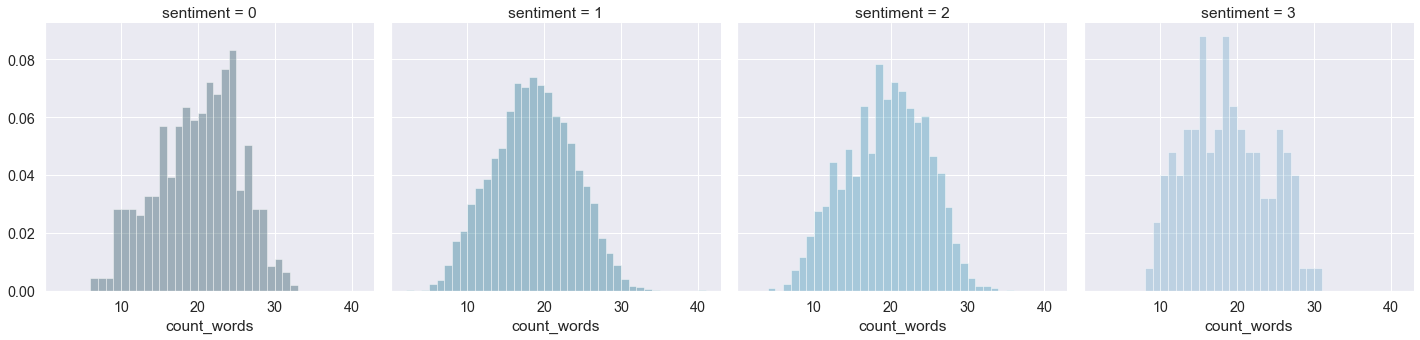

Descriptive stats for count_char
--------------------------------
            count       mean        std   min   25%   50%    75%    max
sentiment                                                              
0          456.0   84.135965  22.090800  25.0  69.0  87.0  102.0  125.0
1          4310.0  79.097216  21.362144  9.0   64.0  82.0  95.0   131.0
2          2382.0  80.727120  21.536434  18.0  66.0  84.0  98.0   129.0
3          125.0   77.976000  22.314997  25.0  61.0  79.0  96.0   125.0


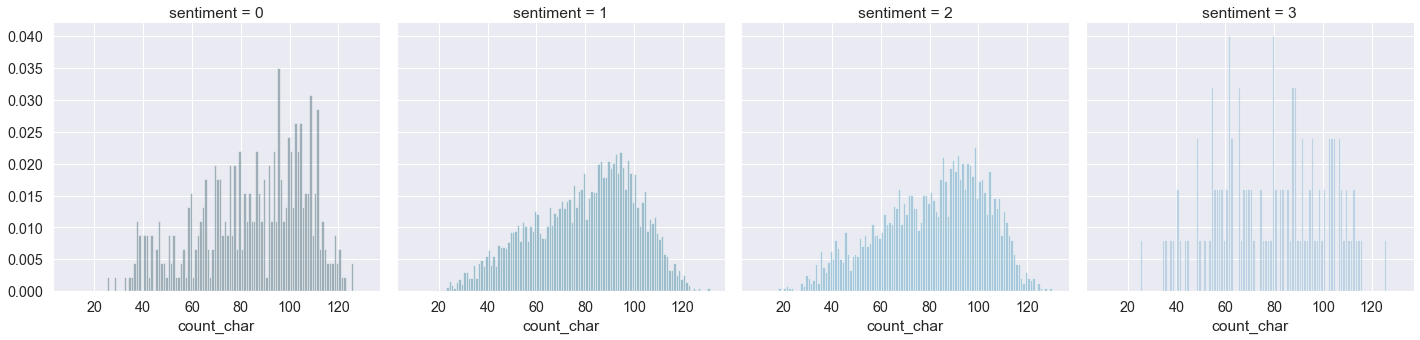

Descriptive stats for count_digit
---------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.559211  1.282512  0.0  0.0  0.0  1.0  10.0
1          4310.0  0.875638  2.080830  0.0  0.0  0.0  1.0  17.0
2          2382.0  0.655332  1.200942  0.0  0.0  0.0  1.0  16.0
3          125.0   0.672000  1.378264  0.0  0.0  0.0  1.0  10.0


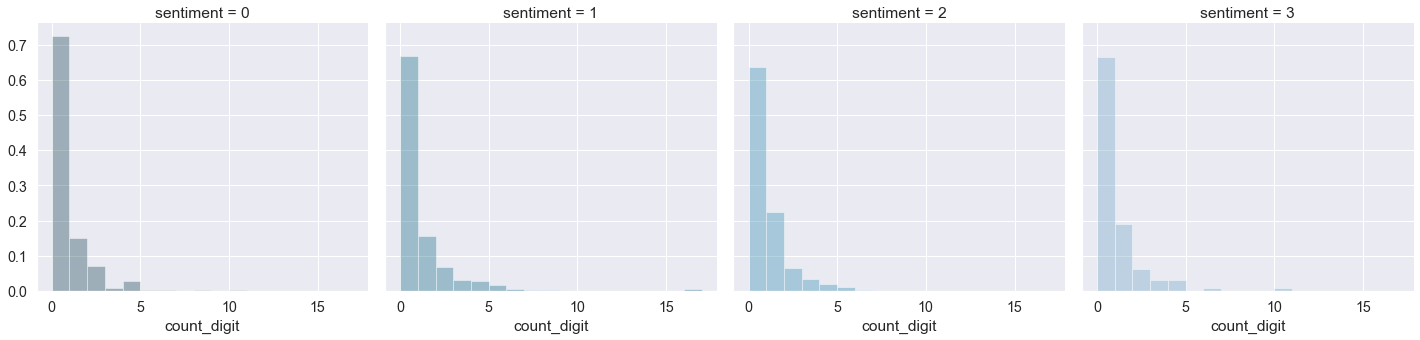

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.552632  0.739374  0.0  0.0  0.0  1.0  4.0
1          4310.0  0.850348  0.976455  0.0  0.0  1.0  1.0  8.0
2          2382.0  0.740134  0.838025  0.0  0.0  1.0  1.0  5.0
3          125.0   0.640000  0.962188  0.0  0.0  0.0  1.0  5.0


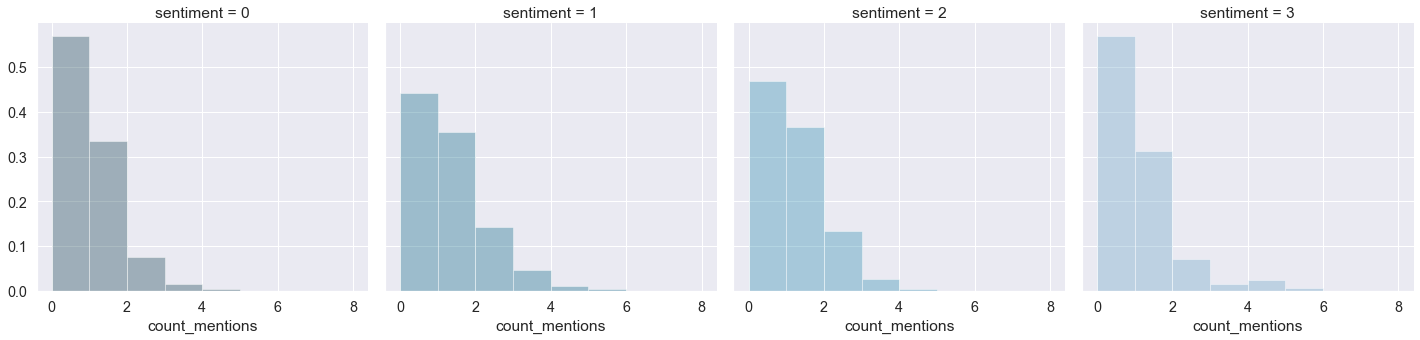

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   1.605263  0.839868  1.0  1.0  1.0  2.0  6.0 
1          4310.0  1.792575  1.180463  0.0  1.0  1.0  2.0  12.0
2          2382.0  1.683039  0.952835  0.0  1.0  1.0  2.0  7.0 
3          125.0   1.600000  0.950382  1.0  1.0  1.0  2.0  5.0 


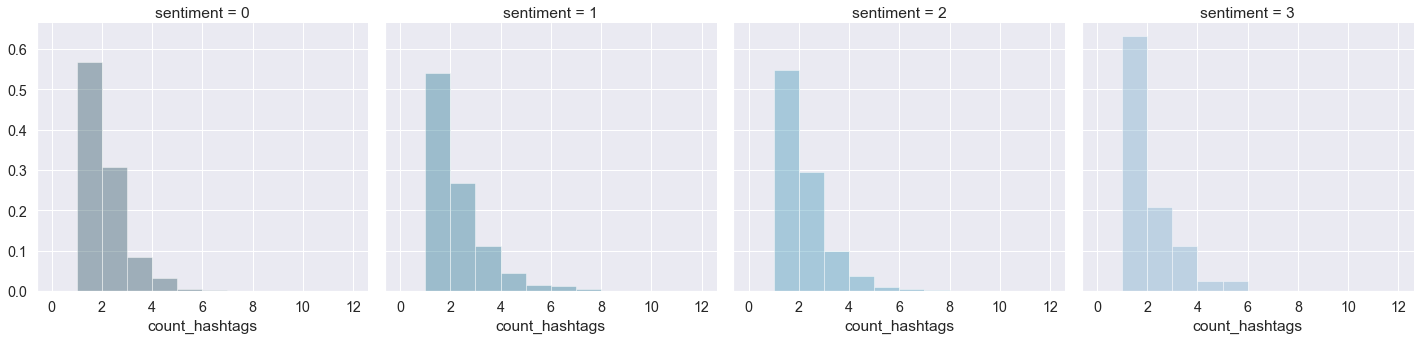

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.901316  1.199413  0.0  0.0  1.0  1.0  18.0
1          4310.0  1.110209  1.060554  0.0  0.0  1.0  2.0  17.0
2          2382.0  1.033165  0.963940  0.0  0.0  1.0  2.0  6.0 
3          125.0   0.976000  0.919888  0.0  0.0  1.0  1.0  4.0 


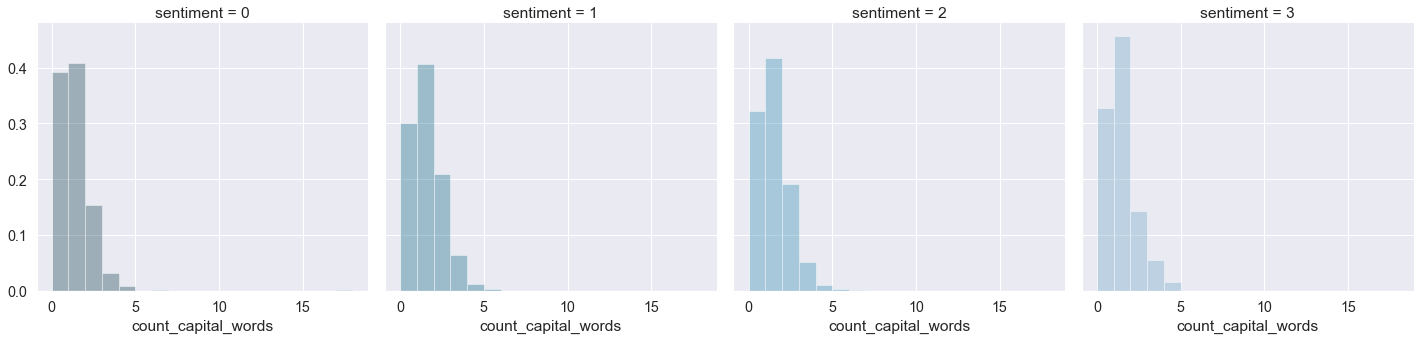

Descriptive stats for count_fCap
--------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   3.263158  2.340480  0.0  2.0  3.0  4.0  15.0
1          4310.0  3.985383  2.780518  0.0  2.0  3.0  5.0  16.0
2          2382.0  3.587741  2.425294  0.0  2.0  3.0  5.0  14.0
3          125.0   3.072000  2.095217  0.0  2.0  3.0  4.0  12.0


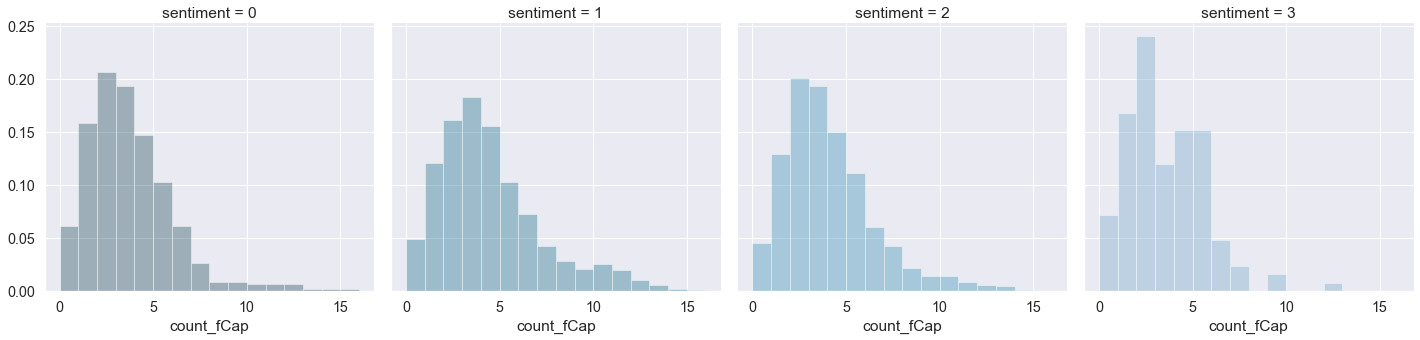

Descriptive stats for count_Elgwords
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.015351  0.123079  0.0  0.0  0.0  0.0  1.0
1          4310.0  0.010673  0.105003  0.0  0.0  0.0  0.0  2.0
2          2382.0  0.009656  0.097809  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


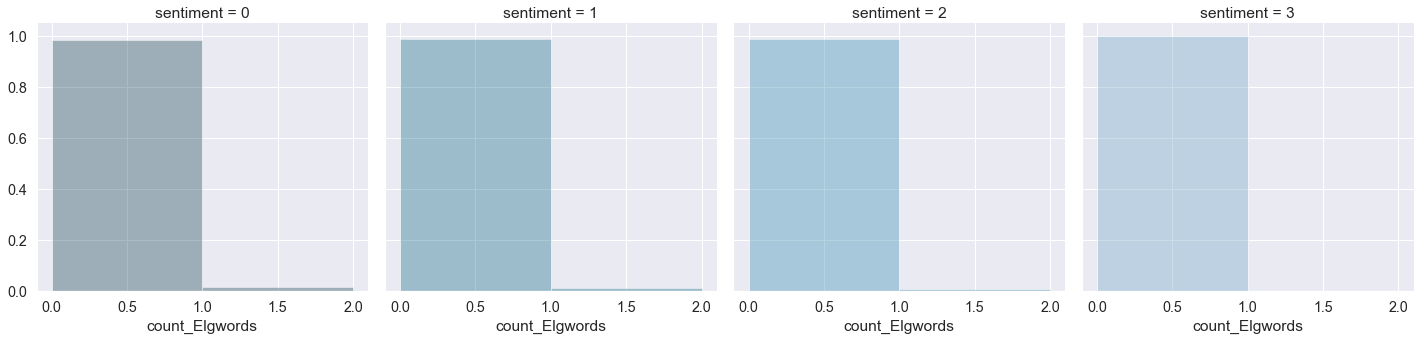

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.361842  0.819134  0.0  0.0  0.0  0.0  8.0 
1          4310.0  0.406265  0.767710  0.0  0.0  0.0  1.0  11.0
2          2382.0  0.548699  0.903084  0.0  0.0  0.0  1.0  9.0 
3          125.0   0.424000  0.825638  0.0  0.0  0.0  1.0  3.0 


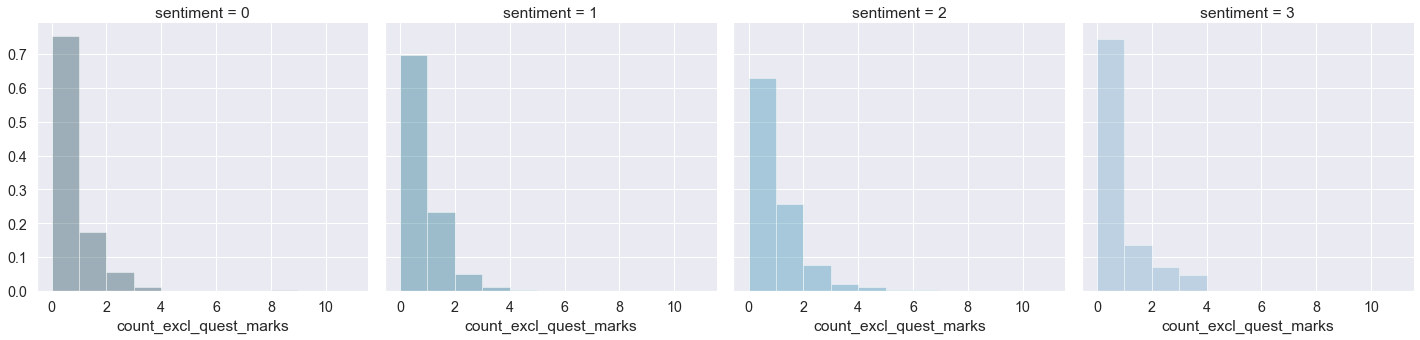

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.004618  0.067813  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


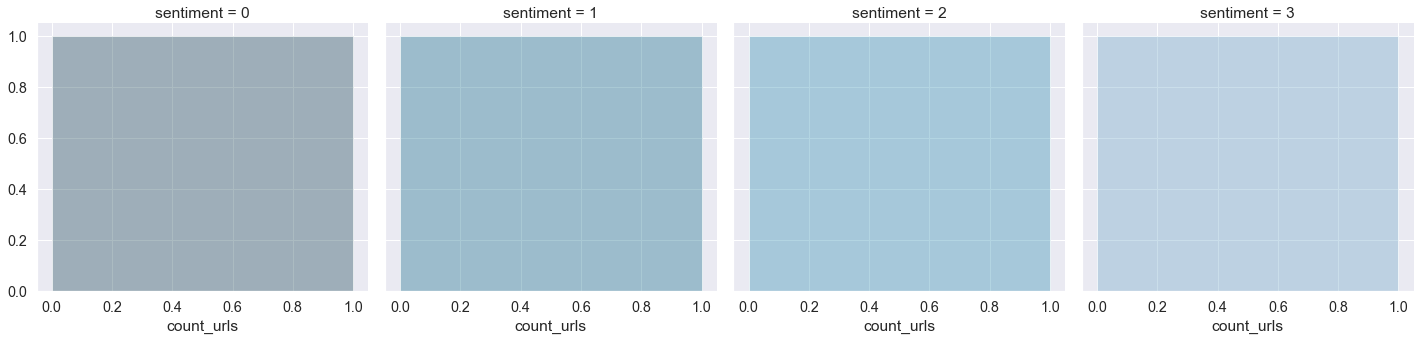

In [66]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    
df_eda = df_train
for i in df_eda.columns.to_list()[:-2]:
    show_dist(df_eda, i)

In [76]:
# create countplot for Target column   Anaji 12:15pm 16 march
def createCP(df,x1):
    sns.countplot(x = x1, data = df)
    plt.title('Sentiment count plot')
    plt.show()

# function for wordcloud 
def createWC(df):
    tweet_all = " ".join(i for i in df.tweet)
    tweet_0 = " ".join(i for i in df[df['sentiment']==0].tweet)
    tweet_1 = " ".join(i for i in df[df['sentiment']==1].tweet)
    tweet_2 = " ".join(i for i in df[df['sentiment']==2].tweet)
    tweet_3 = " ".join(i for i in df[df['sentiment']==3].tweet)

    fig, ax = plt.subplots(5, 1, figsize  = (40,40))
    # Create and generate a word cloud image:
    wc_all = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_all)
    wc_0 = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_0)
    wc_1 = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_1)
    wc_2 = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_2)
    wc_3 = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(tweet_3)

    # 0: Negative,  1: Neutral, 2: Positive, 3: Can't Tell
    # Display the generated image:

    ax[0].imshow(wc_all, interpolation='bilinear')
    ax[0].set_title('All Tweets', fontsize=30)
    ax[0].axis('off')
#     wc_all.to_file('wc_all.png')
    ax[1].imshow(wc_0, interpolation='bilinear')
    ax[1].set_title('Tweets under Negative Sentiment',fontsize=30)
    ax[1].axis('off')
#     wc_0.to_file('wc_0.png')
    ax[2].imshow(wc_1, interpolation='bilinear')
    ax[2].set_title('Tweets under Neutral Sentiment',fontsize=30)
    ax[2].axis('off')
#     wc_1.to_file('wc_1.png')
    ax[3].imshow(wc_2, interpolation='bilinear')
    ax[3].set_title('Tweets under Positive Sentiment',fontsize=30)
    ax[3].axis('off')
#     wc_2.to_file('wc_2.png')
    ax[4].imshow(wc_3, interpolation='bilinear')
    ax[4].set_title('Tweets under Can\'t Tell Sentiment',fontsize=30)
    ax[4].axis('off')
#     wc_3.to_file('wc_3.png')


In [71]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
# clean text for train 
ct = CleanText()
df_train = pd.DataFrame()
df_train['clean_tweet'] = ct.transform(df['tweet'])
df_train['sentiment'] = df['sentiment']


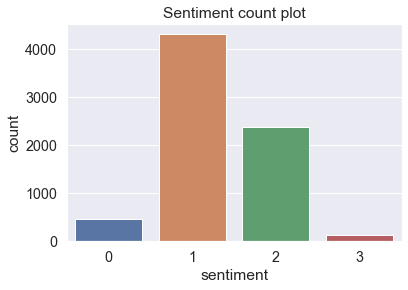

In [74]:
x = df.columns.tolist()[-1]   # last column is Target 'sentiment''
createCP(df, x)


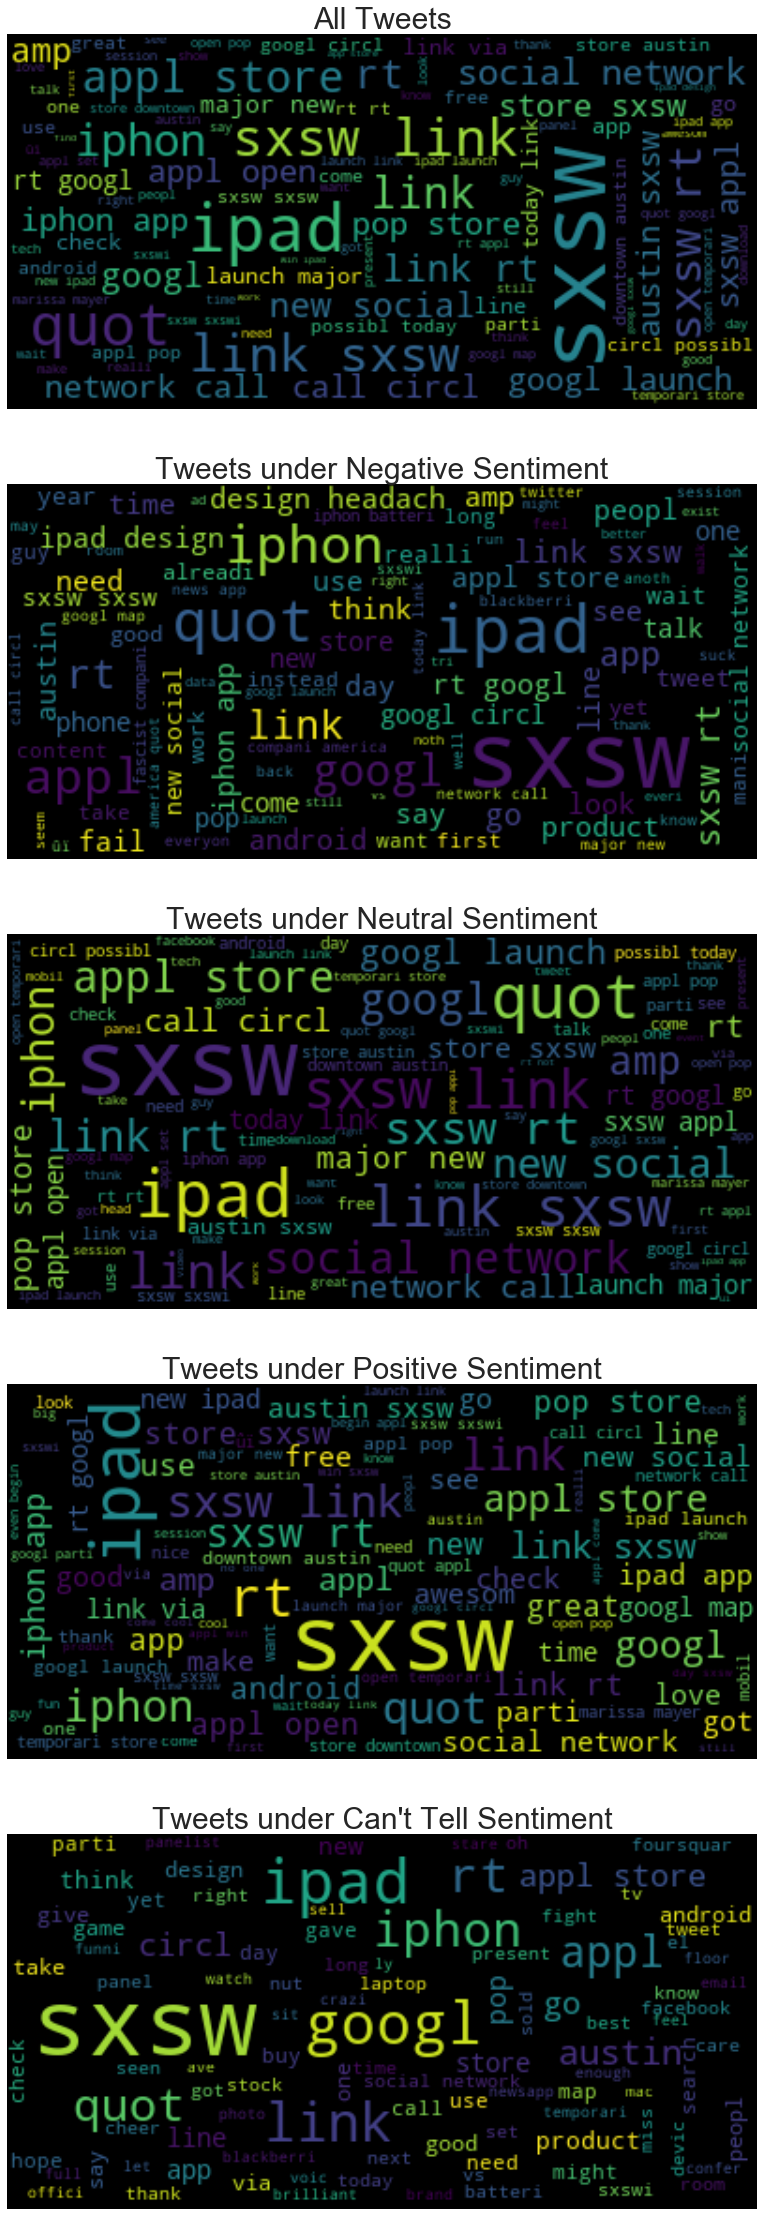

In [77]:
df_train['tweet'] = df_train['clean_tweet']
createWC(df_train)

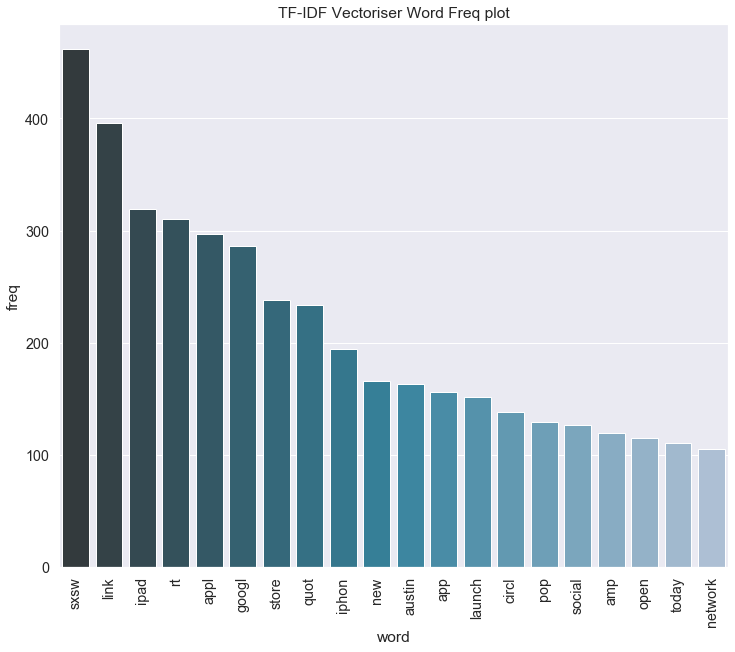

In [99]:
# TfidfVectorizer Classifier
cv = TfidfVectorizer()
bow = cv.fit_transform(df_train['clean_tweet'])
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('TF-IDF Vectoriser Word Freq plot')
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.xticks(rotation=90)
plt.show();

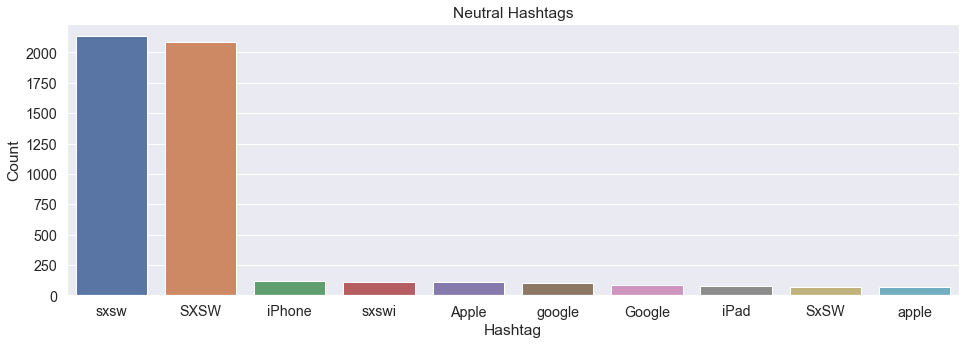

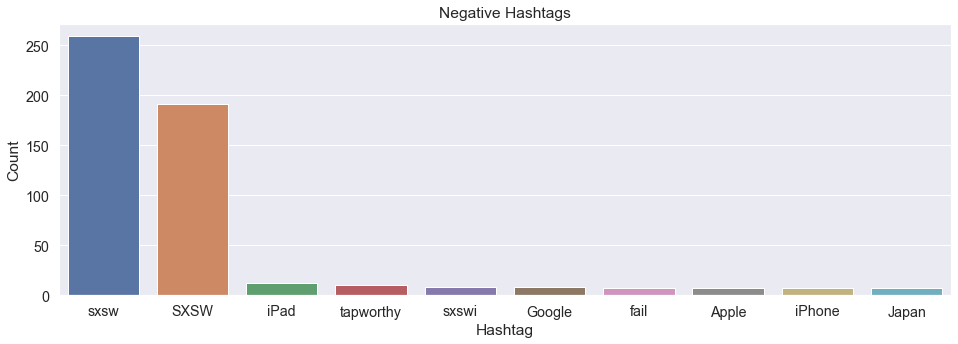

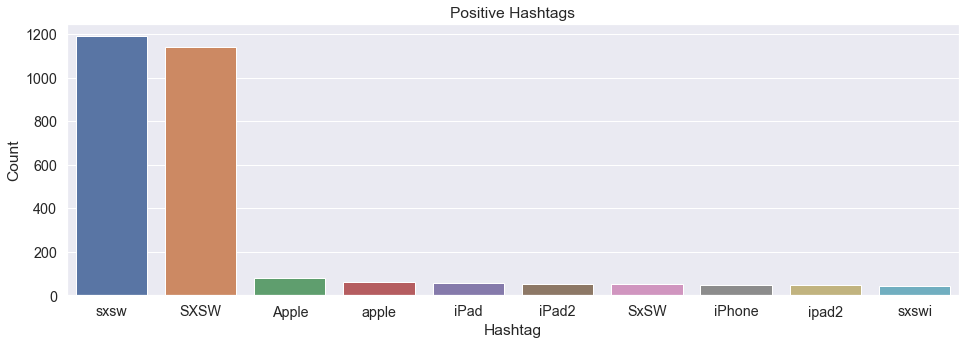

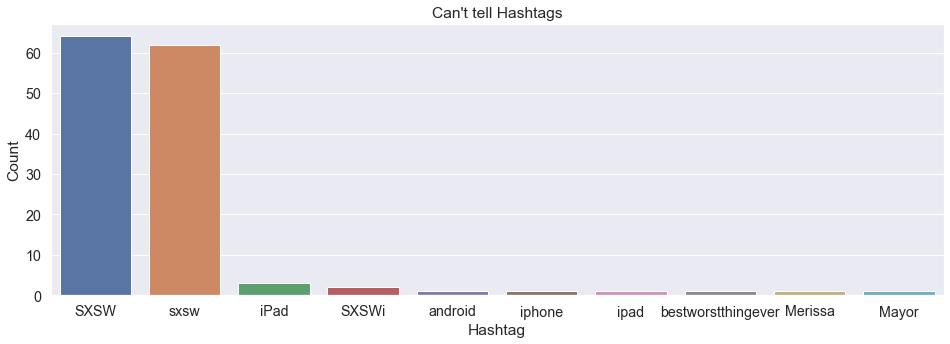

In [107]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# extracting hashtags from  tweets
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
HT_negative = hashtag_extract(df['tweet'][df['sentiment'] == 0])
HT_neutral = hashtag_extract(df['tweet'][df['sentiment'] == 1])
HT_positive = hashtag_extract(df['tweet'][df['sentiment'] == 2])
HT_cantell = hashtag_extract(df['tweet'][df['sentiment'] == 3])
# unnesting list
HT_neutral = sum(HT_neutral,[])
HT_negative = sum(HT_negative,[])
HT_positive = sum(HT_positive,[])
HT_cantell = sum(HT_cantell,[])
HT_sum_list = [HT_neutral,HT_negative,HT_positive,HT_cantell]
HT = ['Neutral Hashtags','Negative Hashtags','Positive Hashtags','Can\'t tell Hashtags']
for i,j in zip(HT_sum_list,HT):
    a = nltk.FreqDist(i)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 10 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 10) 
    plt.figure(figsize=(16,5))
    plt.title(j)
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    ax.set(ylabel = 'Count')
    plt.show()

In [ ]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer(stop_words = 'english')  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()        # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    
    return f1

#trainning
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred



# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

In [ ]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
CV = CountVectorizer(stop_words = 'english')   # CountVectorizer()
Xc = CV.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = CV.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()       # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    
    return f1

#trainning
X = Xc
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred



# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

In [ ]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
Hv = HashingVectorizer(stop_words = 'english')       # HashinhVectorizer
Xh = Hv.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = Hv.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()         # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    
    return f1

#trainning
X = Xh
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred



# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

### Final Model on TF-IDF Classifier and LogisticRegression Model

In [130]:
path = 'data/train.csv'
data = load_Data(path)
df = Train_Preprocess(data)
print("Load Train Data.....")

# clean text for train 
ct = CleanText()
df_train = pd.DataFrame()
df_train['clean_tweet'] = ct.transform(df['tweet'])
df_train['sentiment'] = df['sentiment']
X = df_train['clean_tweet']
y = df_train['sentiment']
print("Clean Train Data.....")

tfidf = TfidfVectorizer(stop_words = 'english')        #TF-IDF Vectoriser
X = tfidf.fit_transform(X)                             # Fit and Transfer TF-IDF Vectoriser
print("TfidfVectorizer Train Data.....")

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()                       # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='micro')
    return f1

#trainning
f1 = LogReg(X,y)   
print('f1 score Train Data is:',f1)
print("Training Complete.....")

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred

path = 'data/test.csv'
data = load_Data(path)
# Storing the Id column ID
ID,Test_df = Test_Preprocess(data)
print("Load Test Data......")

df_test = pd.DataFrame()
ct = CleanText()
df_test['clean_tweet'] = ct.transform(Test_df['tweet'])
print("Clean Test Data.....")

X_test = df_test['clean_tweet']
X_test = tfidf.transform(X_test)                     # Transfer TF-IDF Vectoriser Not Fit_transfer and not initialise again
print("TfidfVectorizer Test Data.....")

#predicting on test file
y_pred = pd.DataFrame(prediction(X_test),columns=['sentiment']) 
# print(y_pred['sentiment'].value_counts())
submission = pd.concat([ID,y_pred['sentiment']],1)
print("Saving submission File.....")
submission.to_csv('submission.csv',index=False)
submission.head()

Load Train Data.....
Clean Train Data.....
TfidfVectorizer Train Data.....
f1 score Train Data is: 0.6776632302405499
Training Complete.....
Load Test Data......
Clean Test Data.....
TfidfVectorizer Test Data.....
Saving submission File.....


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2
